<img src="https://www.rochester.edu/assets/images/ur-logo.svg">

# <center>[CSC 249/449: Machine Vision](https://www.cs.rochester.edu/~cxu22/t/249S22/)</center>


1. Make sure you fill in all cells contain `YOUR CODE HERE` or `YOUR ANSWER HERE`.
2. After you finished, `Restart the kernel & run` all cell in order.
---------


# Motion Estimation

This project helps you get your hands on estimating pixel motion by solving **optical flow** problem. Given two consecutive frames with small motion, the machine should be able to estimate the motion by following **brightness constancy**.

As discussed in the class, we can transform the problem of motion estimation into solving the equation with **brightness constancy** and **spatial coherence** constraints:

$$
\nabla I(p_i) \cdot [u,v] + I_t(p_i) = 0
$$

The number of equations per pixel is related to the selected window size. 

In this project, the overall pipeline is decomposed to two parts:

1. **Compute Gradients**: You will need to get the image gradients along x, y, and also the time axes. You should be familiar with this since you have already experienced how to compute gradients in the previous problem set.
2. **Flow Estimation**: Given the image gradients, you will solve the aperture problem to obtain the $[u,v]$ for pixels. 

In [3]:
import cv2
import csc249
import numpy as np
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Next Img')

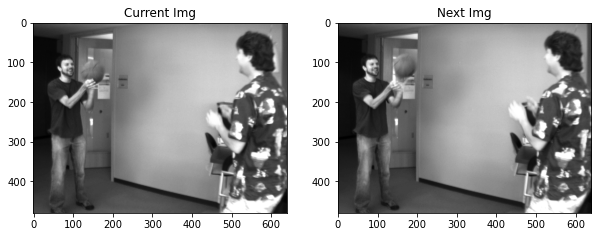

In [4]:
# read current frame and the next frame
img_cur = cv2.cvtColor(cv2.imread(str(csc249.data/'basketball1.png')), cv2.COLOR_BGR2GRAY)
img_next = cv2.cvtColor(cv2.imread(str(csc249.data/'basketball2.png')), cv2.COLOR_BGR2GRAY)
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(img_cur, cmap='gray')
plt.title("Current Img")
fig.add_subplot(1, 2, 2)
plt.imshow(img_next, cmap='gray')
plt.title("Next Img")

##  Compute Gradients

Recall the steps of image filtering and gradients:

1. Generate image filters along $x$, $y$, and $time$ axes, respectively.
2. Apply the filters on images to get the gradients 
    * The filters X, Y should be applied on the current image, while the gradients should be computed from both the current and the next image
    * Use `cv2.filter2D` to implement the filtering    

In [5]:
# return X,Y,T filters
def firstorder():
    """
    Returns:
    --------
        filter X: numpy.ndarray
        filter Y: numpy.ndarray  
        filter T: numpy.ndarray
    """
    # 
    X = np.array([[-1,1]])
    Y = np.array([[-1],[1]])
    T = np.array([[1,-1]])
    
    return {'filterX': X,
            'filterY':Y, 
            'filterT': T}

If correctly implemented, you should get three filters that will be passed into the next function.

In [6]:
# compute gradients on images
def get_gradient(img_cur, img_next, filters):
    """
    Arguments:
    ----------
        img_cur, img_next : the current and the next grayscale images
            A 2D numpy.ndarray of shape H x W.
        filters: filters
            a dictonary of numpy.ndarray
    Returns:
    --------
        grad_x, grad_y, grad_t: numpy.ndarray
            H x W array of gradients in image coordinates
    """
    X = filters['filterX']
    Y = filters['filterY']
    T = filters['filterT']
    # 
    gx = cv2.filter2D(img_cur,ddepth=-1,kernel=X)
    gy = cv2.filter2D(img_cur,ddepth=-1,kernel=Y)
    gt = T[0,0]*img_next-T[0,1]*img_cur
    return {'grad_x': gx, 
            'grad_y': gy, 
            'grad_t': gt}

## Flow Estimation

Refer to the class, solving the aperture problem can help get the pixel movement $[u,v]$. Other than estimating motion on all the pixels, we first detect a set of good feature points. In this case, you are actually iterating the flow estimation on the selected points. The function involves the following steps:

1. Unpack the [x,y] coordinates from the detected corners
    * The return coordinates are in [y,x] format
2. Compute the $I_x$, $I_y$ and $I_t$ for each neighbors inside the window
    * The $I_x$, $I_y$ and $I_t$ may be in 2D shape, you can use `.flatten()` to make them into 1D arrays
3. If you use 5x5 for the windows, now you will have 25 equations to compute the $(u,v)$ for each pixel. The overall equation is $A$$d$ = $b$ (the same as in class materials). Then you can get this $(u,v)$ by solving least squares problem
    * Hint: use `np.linalg.pinv()` function to get the matrix that solves the least-squares problem
4. After running over all the detected points, return the updated flow
    

In [7]:
def solving_aperture(flow, corners, grads, window_size):
    """
    Arguments:
    ----------
        flow: the initial flow with all pixels of zero values
            Two 2D numpy.ndarray [u, v] of shape H x W.
        corners: the detected strong corners on image
            a list of [y, x] coordinates
        grads: the image gradients
        window_size: the number of neighbors/equations to compute [u,v] 
    Returns:
    --------
        u, v: numpy.ndarray
            two H x W arrays representing the flow
    """
    # extract gradients
    gx = grads['grad_x']
    gy = grads['grad_y']
    gt = grads['grad_t']
    
    # extract u, v
    u = flow['u']
    v = flow['v']
    
    # 
    #version1:use window
    H,W = u.shape
    for y,x in corners:
        local_w = window_size
        #in case of out of bound
        dis_to_edge = min(H-1-x,x,W-1-y,y)
        if dis_to_edge < window_size//2:
            local_w = dis_to_edge*2+1
            
        Ix = np.zeros((local_w,local_w))
        Iy = np.zeros((local_w,local_w))
        It = np.zeros((local_w,local_w))
        for i in range(x-local_w//2,x+local_w//2+1):
            for j in range(y-local_w//2,y+local_w//2+1):
                Ix[i-(x-local_w//2)][j-(y-local_w//2)] = gx[i][j]
                Iy[i-(x-local_w//2)][j-(y-local_w//2)] = gy[i][j]
                It[i-(x-local_w//2)][j-(y-local_w//2)] = gt[i][j]
        
        Ix = Ix.flatten().reshape((local_w**2,1))
        Iy = Iy.flatten().reshape((local_w**2,1))
        It = It.flatten().reshape((local_w**2,1))
        A = np.append(Ix,Iy,axis=1)
        b = -It
        uv = np.linalg.pinv(A).dot(b)
        l_u = uv[0]
        l_v = uv[1]
#         for i in range(x-local_w//2,x+local_w//2+1):
#             for j in range(y-local_w//2,y+local_w//2+1):
#                 u[i][j] = l_u/20
#                 v[i][j] = l_v/20
        u[x][y] = l_u/6
        v[x][y] = l_v/6

    #version2:do not use window
#     for y,x in corners:
#         Ix = gx[x][y]
#         Iy = gy[x][y]
#         It = gt[x][y]
#         A = np.array([[Ix,Iy]])
#         b = -np.array([[It]])
#         uv = np.linalg.pinv(A).dot(b)
#         l_u = uv[0]
#         l_v = uv[1]
#         u[x][y] = l_u/7
#         v[x][y] = l_v/7
#     raise NotImplementedError()
    
    return {'u':u,
           'v':v}

In [8]:
# import os
# print(os.path.dirname(csc249.__file__))

## Visualization


If you got it right so far, you should be able to get your flow visualization similar to this:

![alt text](result.png "Flow Result Example")


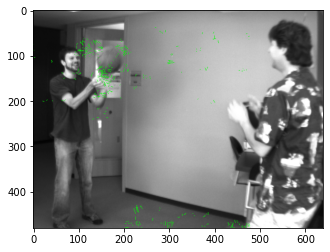

In [9]:
max_corners=10000
min_quality=0.01
min_distance=0.1
corners = cv2.goodFeaturesToTrack(img_cur, max_corners, min_quality, min_distance)
# print(corners.size)
corners = np.squeeze(corners).astype(int)

img_cur = img_cur / 255
img_next = img_next / 255

filters = firstorder()

grads = get_gradient(img_cur, img_next, filters)

# initialize the flow
u = np.zeros(img_cur.shape)
v = np.zeros(img_cur.shape)
flow = {'u':u, 'v':v}

# sovling aperture problem
flow = solving_aperture(flow, corners, grads, window_size=5)

# show results
img_to_show = cv2.cvtColor((img_next*255).astype('uint8'), cv2.COLOR_GRAY2RGB)
csc249.plotFlow(img_to_show, flow)

# Submission

1. At the menubar, click `Kernel`$\rightarrow$ `Restart & Run All`
2. Download the zip file and upload via blackboard
   
1% deduction of late assignment total score per hour passing the deadline.

In [10]:
# import csc249
# csc249.make_submission()